# Importation des données et information sur le VGG16 

$\underline{Importation}$

On commence par importer les packages nécessaires pour le deep learning. On fera intervenir une architecture de réseau qui est connu : VGG16

In [6]:
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.applications.vgg16 import preprocess_input
from utils.canvas_embedding import *
import matplotlib.pyplot as plt
import numpy as np

Keras fournit une fonction appelée preprocess_input() pour préparer une nouvelle entrée pour le réseau.

In [7]:
img_width, img_height = 299,299 #car le reseau VGG16 prend en entrée cette dimension
train_data_dir = 'C:/Users/na_to/OneDrive/Bureau/Insa/Mapromo/ML3/Exercices/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'C:/Users/na_to/OneDrive/Bureau/Insa/Mapromo/ML3/Exercices/Data/chihuahua-vs-muffin/validation'

train_dataset = keras.preprocessing.image_dataset_from_directory(train_data_dir, image_size=(img_height,img_width), batch_size=32, label_mode = 'categorical', shuffle=False)
eval_dataset = keras.preprocessing.image_dataset_from_directory(validation_data_dir, image_size=(img_height,img_width), batch_size=32, label_mode = 'categorical', shuffle=False)

preprocessed_train_dataset = train_dataset.map(lambda data, labels: (preprocess_input(data), labels))
preprocessed_eval_dataset = eval_dataset.map(lambda data, labels: (preprocess_input(data), labels))

Found 568 files belonging to 2 classes.
Found 142 files belonging to 2 classes.


    On a 568 images dans le train avec 2 classes muffin et chihuahua.
    On a 142 images dans la validation avec 2 classes muffin et chihuahua

$\underline{ModelVGG16}$

In [8]:
modelVGG16 = applications.VGG16(include_top=False, weights='imagenet', pooling='max')

Lors de la première exécution, Keras télécharge les poids depuis Internet.  
Les poids ne sont téléchargés qu'une seule fois. si on re-execute, les pondérations seront chargées localement et le modèle devrait être prêt à l'emploi en quelques secondes.

    Include_top = False : On n'inclut pas les 3 couches entièrement connectées à la fin du réseau. 
    weights='imagenet' : pré-entrainement sur les images de ImageNet
    pooling='max' : signifie que le max pooling est appliquée 

On peut afficher la structure de l'architecture ci-dessous

In [11]:
print(modelVGG16.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

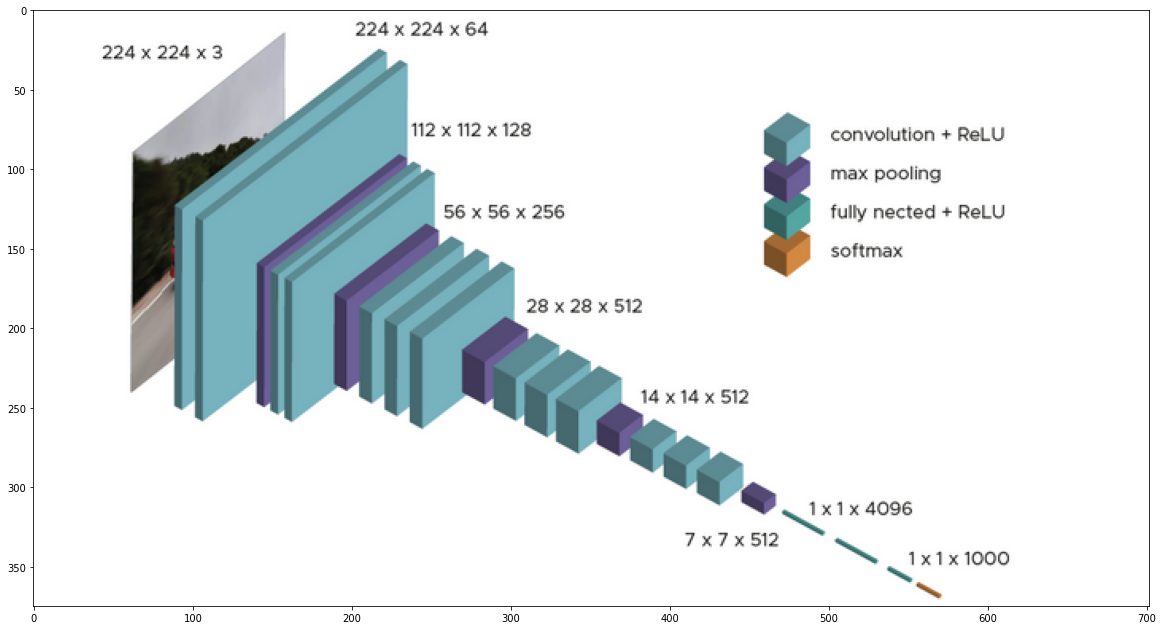

In [5]:
from matplotlib import image
img = image.imread("VGG16.png")
fig = plt.figure(1, figsize=(20, 20))
plt.imshow(img)
plt.show()

Voici l'architecture du VGG16. Le reseau prend entrée les images de dimension (224,224,3). 

    3 : couleurs Rouge, vert et bleu
    (224,224): la taille de l'image en longueur et largeur.
    
Le reseau est consistué de plusieurs couches de convolution + relu / max pooling / fully connected + relu / une fonction d'activation softmax en sortie.

$\underline{Prediction}$

In [12]:
%%time
train_data_processed = modelVGG16.predict(preprocessed_train_dataset)
test_data_processed = modelVGG16.predict(preprocessed_eval_dataset)

Wall time: 2min 23s


On appele la fonction predict() sur le modèle afin d'obtenir une prédiction de la probabilité que l'image appartienne à chacun des 2 classes : chihuahua et muffin. On l'applique sur les données d'entrainements et de validation.

In [13]:
train_labels = np.concatenate([label for data, label in preprocessed_train_dataset], axis=0)
test_labels = np.concatenate([label for data, label in preprocessed_eval_dataset], axis=0)

On crée les variables cibles $\textbf{train_label}$ et $\textbf{test_label}$ pour qu'on puisse évaluer les performances obtenues.

In [14]:
test_labels.shape 

(142, 2)

Par exemple pour $\textbf{test_label}$ notre variable a 142 images et contient 2 labels (chihuahua et muffin)

# La fin du réseau

Pour rappel, on n'a pas inclut les 3 couches entièrement connectées à la fin du réseau. 
On applique un algorithime de classification c'est à dire le Support Vector Machine. 

On crée un pipeline qui consiste à mettre les données à la même échelle et on applique notre algorithme de classification.

In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_target_sklearn = np.argmax(train_labels,axis=1)
test_target_sklearn = np.argmax(test_labels,axis=1)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())])

clf.fit(train_data_processed, train_target_sklearn)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

In [17]:
clf.score(test_data_processed,test_target_sklearn)

0.9929577464788732

On obtient un score d'accuracy d'environ 99% si on evalue notre modèle avec les données de validation. Il s'agit d'un score qui est quasiment parfait, il serait intéressant d'évaluer ses performances sur les nouvelles données Test par la suite.

# TSNE

On peut utiliser TSNE qui est un outil de visualisation de données de grande dimension. Grâce à cet outil on peut voir visuellement comment les données ont été classé

In [18]:
train_data = np.concatenate([data for data, label in train_dataset], axis=0)
test_data = np.concatenate([data for data, label in eval_dataset], axis=0)

In [19]:
data = np.concatenate((train_data,test_data))
data_processed = np.concatenate((train_data_processed,test_data_processed))
targets_sklearn = np.concatenate((train_target_sklearn,test_target_sklearn))

In [20]:
from sklearn.manifold import TSNE

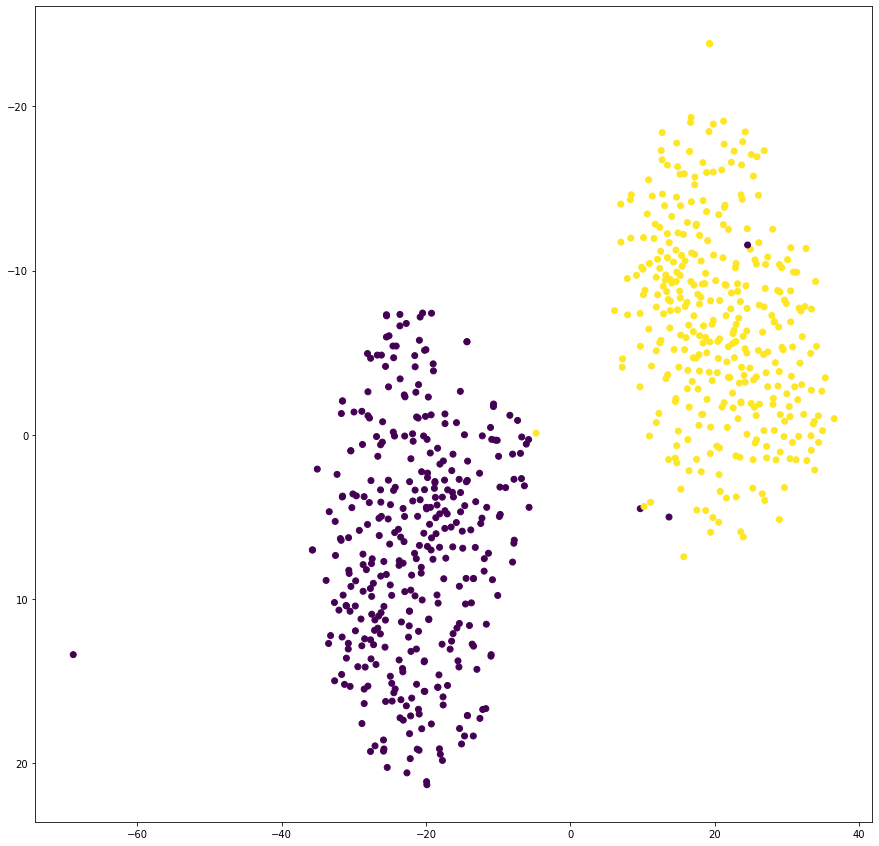

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csgraph

embedding = TSNE()
data_umaped = embedding.fit_transform(data_processed)
plt.figure(figsize=(15,15))
plt.scatter(data_umaped[:,1],data_umaped[:,0],c=targets_sklearn)
plt.gca().invert_yaxis()

On peut observer qu'on a une très fabile minorité de points qui on été mal classé. Tous les points violets à gauche du graphique sont ceux qui ont été bien classé et tous les points en jaune à droite du graphique sont ceux qui on été bien classé

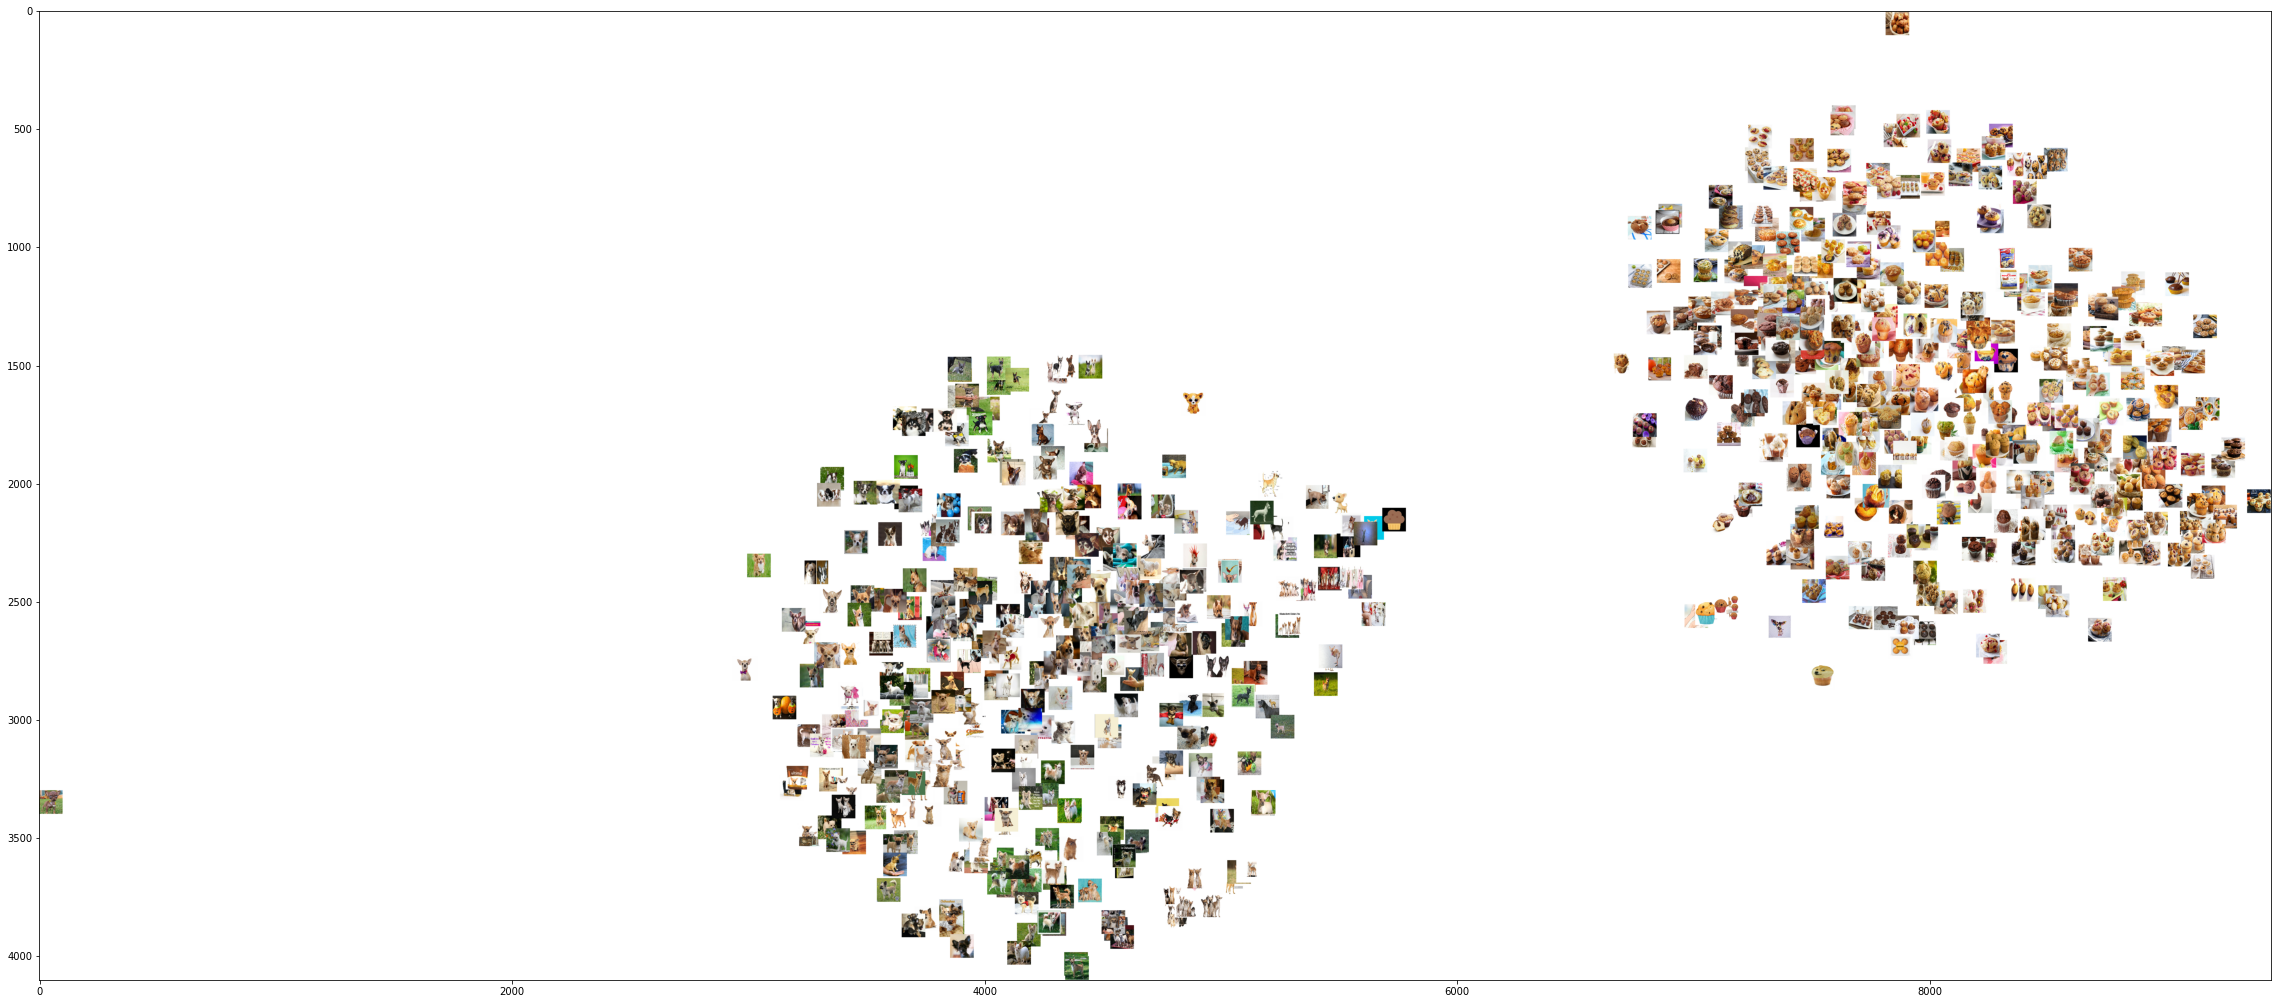

In [22]:
canvas_umap = image_scatter(data_umaped,data,100)
plt.figure(figsize=(40,40))
plt.imshow(canvas_umap)

Au lieu d'afficher les points, on peut observer les images qui ont été bien classés par le réseau de neurones

# Performances sur les données Test 

Il serait maintenant intéressant d'utiliser les performances du modèle sur un nouveau jeu de données Test. On applique le même schéma que précédement.

$\underline{Performance}$

In [24]:
test_data_dir = 'C:/Users/na_to/OneDrive/Bureau/Insa/Mapromo/ML3/Exercices/Data/chihuahua-vs-muffin/test' 

test_dataset = keras.preprocessing.image_dataset_from_directory(test_data_dir, image_size=(img_height,img_width), batch_size=32, label_mode = 'categorical', shuffle=False)
preprocessed_test_dataset = test_dataset.map(lambda data, labels: (preprocess_input(data), labels))

Found 16 files belonging to 2 classes.


In [25]:
vrai_test_data_processed = modelVGG16.predict(preprocessed_test_dataset)

In [26]:
vrai_test_labels = np.concatenate([label for data, label in preprocessed_test_dataset], axis=0)

In [27]:
vrai_test_labels.shape

(16, 2)

In [28]:
vrai_test_target_sklearn = np.argmax(vrai_test_labels,axis=1)

In [29]:
clf.score(vrai_test_data_processed,vrai_test_target_sklearn)

1.0

On obtient un score parfait sur ce nouveau jeux de données. Je trouve ceci cohérent car on a que 16 images dans la base de données test et le réseau qui a été entrainé est le VGG16 qui un réseau très performant car il a été pré-entrainé par les images présent sur ImageNet. On s'attendait à avoir un très bon résulat sur un nouveau jeux de données.

$\underline{Visualisation}$

In [30]:
vrai_test_data = np.concatenate([data for data, label in test_dataset], axis=0)

In [31]:
data_bis = np.concatenate((train_data,vrai_test_data))
data_processed_bis = np.concatenate((train_data_processed,vrai_test_data_processed))
targets_sklearn_bis= np.concatenate((train_target_sklearn,vrai_test_target_sklearn))

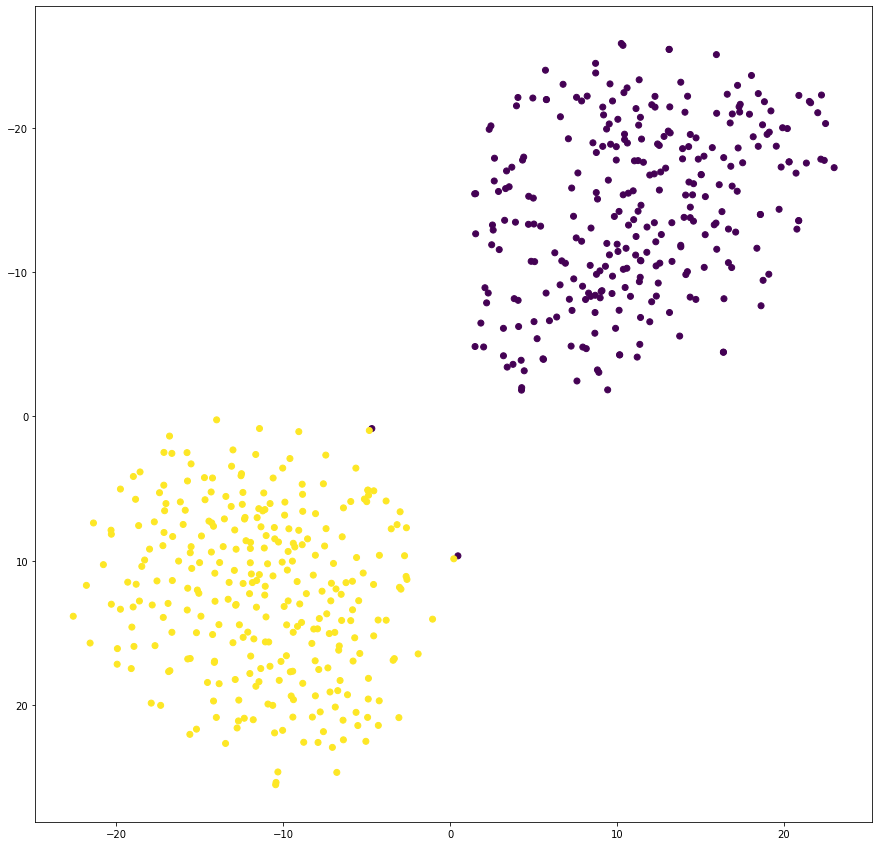

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csgraph

embedding = TSNE()
data_umaped_bis = embedding.fit_transform(data_processed_bis)
plt.figure(figsize=(15,15))
plt.scatter(data_umaped_bis[:,1],data_umaped_bis[:,0],c=targets_sklearn_bis)
plt.gca().invert_yaxis()

On observe bien que toutes les images ont été bien classé sur le schéma.

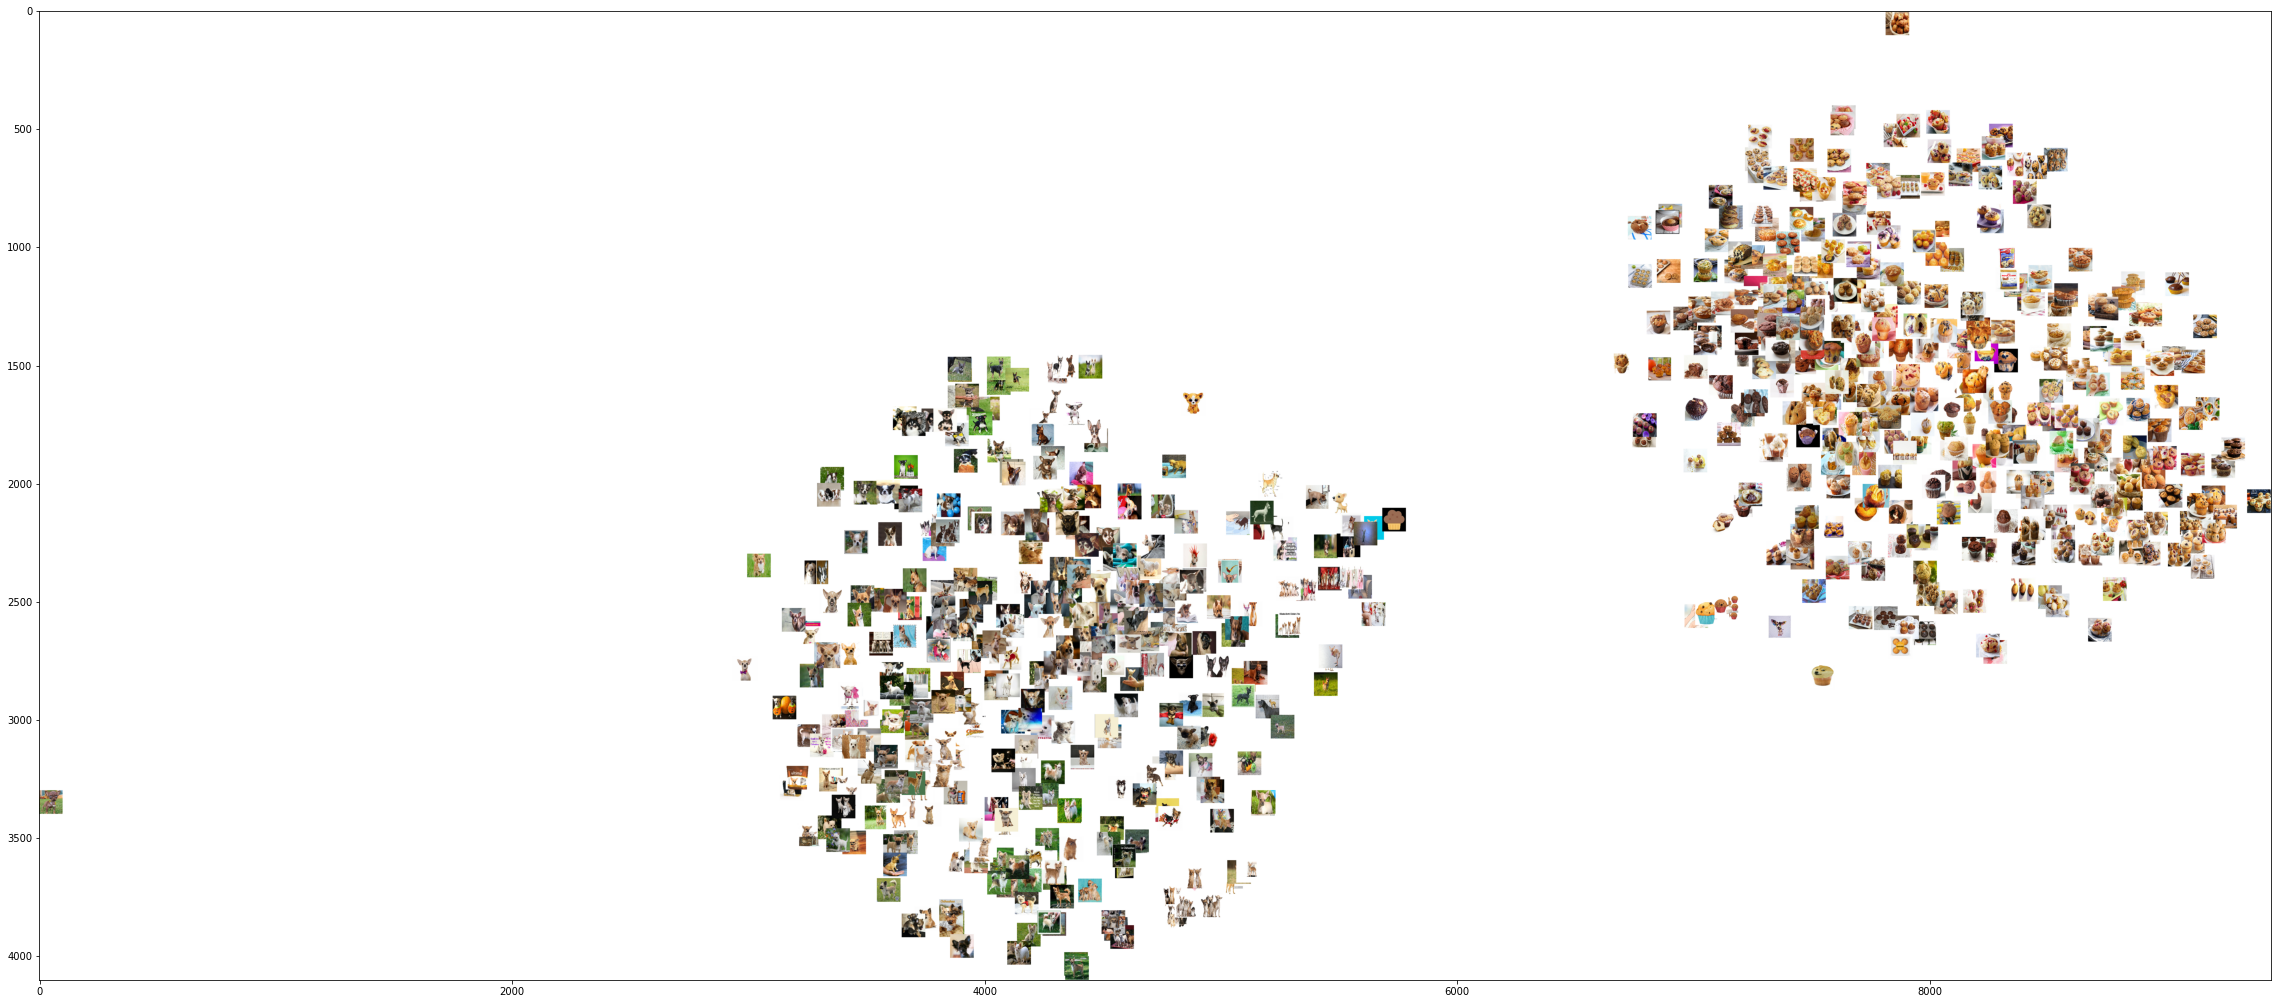

In [33]:
canvas_umap_bis = image_scatter(data_umaped_bis,data,100)
plt.figure(figsize=(40,40))
plt.imshow(canvas_umap)

Voici un autre schéma, si on souhaite visualiser les images à la place des points.